<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/claud30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import io
import os
from google.colab import files


In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to load dataset from local upload
def load_dataset():
    print("Please upload the AEGEAN EMSCAD dataset (CSV file)...")

    try:
        # Prompt user to upload file
        uploaded = files.upload()

        if not uploaded:
            raise ValueError("No file was uploaded")

        # Get the filename of the uploaded file
        filename = list(uploaded.keys())[0]
        print(f"File uploaded: {filename}")

        # Load the dataset
        df = pd.read_csv(filename)
        print(f"Dataset loaded with shape: {df.shape}")

        return df

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Using the fake job postings dataset as a fallback...")

        # If upload fails, use the fake job postings dataset as a fallback
        !wget https://raw.githubusercontent.com/amankharwal/Website-data/master/fake_job_postings.csv
        df = pd.read_csv('fake_job_postings.csv')
        print(f"Fallback dataset loaded with shape: {df.shape}")

        return df

Using device: cpu


In [4]:
# Data preprocessing
def preprocess_data(df):
    print("Original columns:", df.columns.tolist())

    # Handle missing values
    df = df.fillna('')

    # Ensure required columns exist
    required_columns = ['description', 'requirements', 'telecommuting',
                        'has_company_logo', 'has_questions', 'fraudulent']

    # Check if columns exist, otherwise create them
    for col in required_columns:
        if col not in df.columns:
            if col == 'description':
                # Use title and company profile if available
                if 'title' in df.columns and 'company_profile' in df.columns:
                    df[col] = df['title'] + ' ' + df['company_profile']
                else:
                    df[col] = ''
            elif col == 'requirements':
                # Use required qualifications if available
                if 'required_qualifications' in df.columns:
                    df[col] = df['required_qualifications']
                else:
                    df[col] = ''
            elif col in ['telecommuting', 'has_company_logo', 'has_questions']:
                # Default binary features to 0
                df[col] = 0
            elif col == 'fraudulent':
                # Check for alternative column names
                if 'fake' in df.columns:
                    df[col] = df['fake']
                else:
                    raise ValueError(f"Required column '{col}' not found in dataset")

    # Extract text features (Description + Profile)
    df['text_data'] = df['description'] + ' ' + df['requirements']

    # Ensure binary features are numeric
    tabular_features = ['telecommuting', 'has_company_logo', 'has_questions']
    for feature in tabular_features:
        df[feature] = pd.to_numeric(df[feature], errors='coerce').fillna(0).astype(int)

    # Ensure target is binary
    df['fraudulent'] = pd.to_numeric(df['fraudulent'], errors='coerce').fillna(0).astype(int)

    print("Preprocessed columns:", df.columns.tolist())
    return df, tabular_features

# Sample a subset of the data if dataset is too large to speed up training
def sample_data(df, max_samples=10000, stratify_col='fraudulent'):
    if len(df) > max_samples:
        print(f"Dataset is large ({len(df)} rows). Sampling {max_samples} rows...")
        # Ensure balanced sampling of fraudulent and non-fraudulent jobs
        sampled_df = df.groupby(stratify_col, group_keys=False).apply(
            lambda x: x.sample(min(len(x), max_samples // 2), random_state=42)
        )
        if len(sampled_df) > max_samples:
            sampled_df = sampled_df.sample(max_samples, random_state=42)
        print(f"Sampled dataset shape: {sampled_df.shape}")
        return sampled_df
    return df

In [5]:
# DistilBERT Tokenizer
class JobDataset(Dataset):
    def __init__(self, texts, tabular_features, labels, tokenizer, max_len=256):
        self.texts = texts
        self.tabular_features = tabular_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        tabular = self.tabular_features[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'tabular_features': torch.FloatTensor(tabular),
            'label': torch.FloatTensor([label])
        }



In [6]:
# Define model architecture
class FakeJobDetector(nn.Module):
    def __init__(self, n_tabular_features):
        super(FakeJobDetector, self).__init__()

        # DistilBERT for text features
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.embedding_dim = self.distilbert.config.hidden_size

        # Freeze BERT parameters to speed up training
        for param in self.distilbert.parameters():
            param.requires_grad = False

        # Normalization/Scaling for tabular features
        self.tabular_normalizer = nn.BatchNorm1d(n_tabular_features)

        # Concatenate text + tabular features
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim + n_tabular_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, tabular_features):
        # Get DistilBERT embeddings
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use CLS token as text representation
        text_features = distilbert_output.last_hidden_state[:, 0]

        # Normalize tabular features
        normalized_tabular = self.tabular_normalizer(tabular_features)

        # Concatenate features
        concat_features = torch.cat((text_features, normalized_tabular), dim=1)

        # Final prediction
        output = self.classifier(concat_features)

        return output

In [7]:
# Training function
def train_model(model, train_dataloader, val_dataloader, epochs=3, learning_rate=2e-5):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Save path for best model
    model_path = 'best_model.pt'

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0

        # Progress bar for training
        train_progress = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for batch in train_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tabular_features = batch['tabular_features'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, tabular_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_progress.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        # Progress bar for validation
        val_progress = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

        with torch.no_grad():
            for batch in val_progress:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                tabular_features = batch['tabular_features'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask, tabular_features)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(outputs.cpu().numpy().flatten().tolist())
                val_labels.extend(labels.cpu().numpy().flatten().tolist())

                val_progress.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy
        val_binary_preds = [1 if p >= 0.5 else 0 for p in val_preds]
        val_accuracy = accuracy_score(val_labels, val_binary_preds)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model to {model_path}!")

    # Load best model
    model.load_state_dict(torch.load(model_path))

    # Plot training/validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_loss.png')
    plt.show()

    return model, train_losses, val_losses


In [8]:
# Evaluate model
def evaluate_model(model, test_dataloader):
    model.eval()
    predictions = []
    raw_predictions = []
    actual_labels = []

    # Progress bar for evaluation
    eval_progress = tqdm(test_dataloader, desc="Evaluating")

    with torch.no_grad():
        for batch in eval_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tabular_features = batch['tabular_features'].to(device)

            outputs = model(input_ids, attention_mask, tabular_features)
            preds = (outputs >= 0.5).float().cpu().numpy()

            predictions.extend(preds.flatten().tolist())
            raw_predictions.extend(outputs.cpu().numpy().flatten().tolist())
            actual_labels.extend(batch['label'].cpu().numpy().flatten().tolist())

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predictions)
    conf_matrix = confusion_matrix(actual_labels, predictions)
    class_report = classification_report(actual_labels, predictions)

    print(f"Test Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Genuine', 'Fraudulent'],
                yticklabels=['Genuine', 'Fraudulent'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Fake Job Detection')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(actual_labels, raw_predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Fake Job Detection')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    plt.show()

    # Save the results
    with open('results.txt', 'w') as f:
        f.write(f"Test Accuracy: {accuracy:.4f}\n")
        f.write(f"ROC AUC: {roc_auc:.4f}\n\n")
        f.write("Confusion Matrix:\n")
        f.write(str(conf_matrix))
        f.write("\n\nClassification Report:\n")
        f.write(class_report)

    # Download the results
    files.download('results.txt')
    files.download('confusion_matrix.png')
    files.download('roc_curve.png')

    return accuracy, conf_matrix, class_report, roc_auc

In [9]:
# Function to create train/val/test splits with stratification
def create_data_splits(df, tabular_features):
    # Prepare features and labels
    X_text = df['text_data'].values
    X_tabular = df[tabular_features].values
    y = df['fraudulent'].values

    # Create train and temporary test sets
    X_text_train, X_text_temp, X_tabular_train, X_tabular_temp, y_train, y_temp = train_test_split(
        X_text, X_tabular, y, test_size=0.3, random_state=42, stratify=y
    )

    # Split temporary test set into validation and test sets
    X_text_val, X_text_test, X_tabular_val, X_tabular_test, y_val, y_test = train_test_split(
        X_text_temp, X_tabular_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Training set: {len(X_text_train)} samples")
    print(f"Validation set: {len(X_text_val)} samples")
    print(f"Test set: {len(X_text_test)} samples")

    # Check class distribution
    print("Class distribution:")
    print(f"  Training: {np.bincount(y_train)}")
    print(f"  Validation: {np.bincount(y_val)}")
    print(f"  Test: {np.bincount(y_test)}")

    return (X_text_train, X_tabular_train, y_train,
            X_text_val, X_tabular_val, y_val,
            X_text_test, X_tabular_test, y_test)


FAKE JOB POSTING DETECTION USING DISTILBERT AND TABULAR FEATURES
This notebook will implement the methodology diagram you provided.
It combines text data (job descriptions and requirements) with
tabular data (telecommuting, logo presence, questions) using a
neural network with DistilBERT embeddings.
Please upload the AEGEAN EMSCAD dataset (CSV file)...


Saving fake_job_postings.csv to fake_job_postings (1).csv
File uploaded: fake_job_postings (1).csv
Dataset loaded with shape: (17880, 18)

Data preview:
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life t

<ipython-input-4-2f474c46f89b>:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


Preparing datasets...

Initializing model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

FakeJobDetector(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

Epoch 1/3 [Train]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.5715 - Val Loss: 0.5452 - Val Acc: 0.7426
Saved best model to best_model.pt!


Epoch 2/3 [Train]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.5200 - Val Loss: 0.4987 - Val Acc: 0.7426
Saved best model to best_model.pt!


Epoch 3/3 [Train]:   0%|          | 0/589 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.4838 - Val Loss: 0.4794 - Val Acc: 0.7505
Saved best model to best_model.pt!


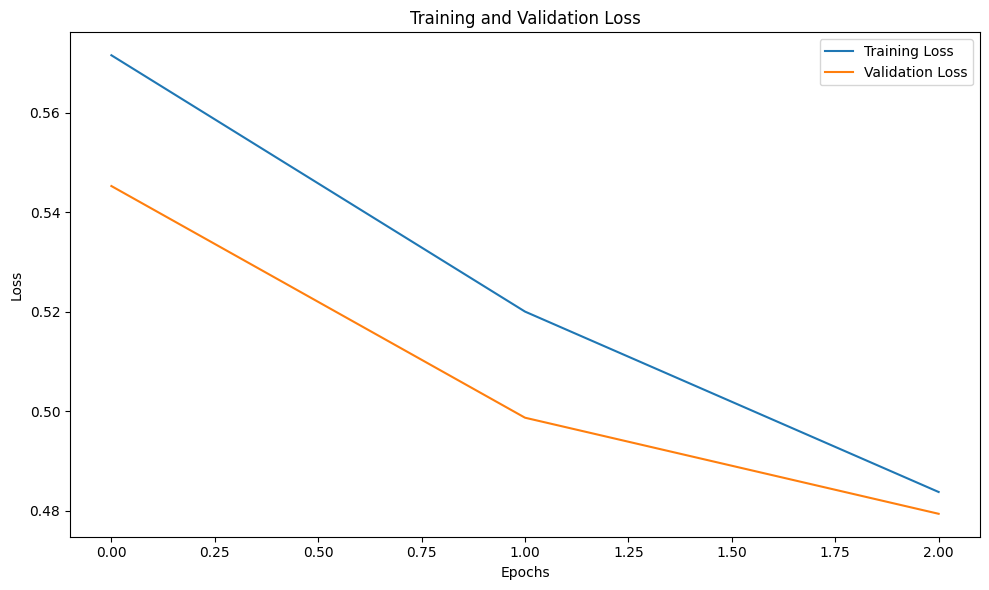


Evaluating model...


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Test Accuracy: 0.7564
Confusion Matrix:
[[372   3]
 [120  10]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86       375
         1.0       0.77      0.08      0.14       130

    accuracy                           0.76       505
   macro avg       0.76      0.53      0.50       505
weighted avg       0.76      0.76      0.67       505



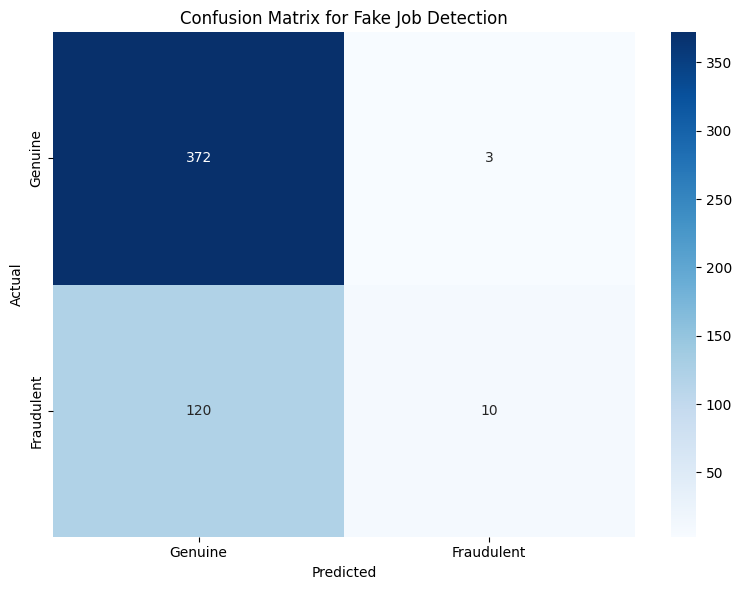

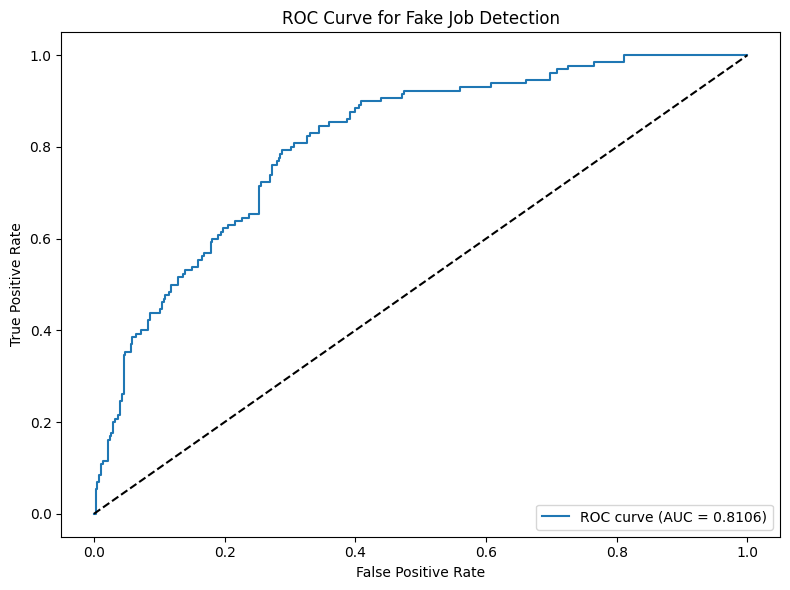

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Training and evaluation complete!
Final model saved as 'fake_job_detector_model.pt'
Test Accuracy: 0.7564, ROC AUC: 0.8106


In [10]:
# Main function
def main():
    # Display instructions
    print("=" * 80)
    print("FAKE JOB POSTING DETECTION USING DISTILBERT AND TABULAR FEATURES")
    print("=" * 80)
    print("This notebook will implement the methodology diagram you provided.")
    print("It combines text data (job descriptions and requirements) with")
    print("tabular data (telecommuting, logo presence, questions) using a")
    print("neural network with DistilBERT embeddings.")
    print("=" * 80)

    # Load dataset from local upload
    df = load_dataset()

    # Explore data
    print("\nData preview:")
    print(df.head())

    print("\nFraudulent job distribution:")
    print(df['fraudulent'].value_counts())
    print(f"Fraudulent jobs: {df['fraudulent'].sum()} ({df['fraudulent'].mean()*100:.2f}%)")

    # Sample data if needed (optional - for faster execution)
    df = sample_data(df, max_samples=5000)  # Adjust based on your hardware constraints

    # Preprocess data
    df, tabular_features = preprocess_data(df)

    # Create train/val/test splits
    (X_text_train, X_tabular_train, y_train,
     X_text_val, X_tabular_val, y_val,
     X_text_test, X_tabular_test, y_test) = create_data_splits(df, tabular_features)

    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Create datasets
    print("\nPreparing datasets...")
    train_dataset = JobDataset(X_text_train, X_tabular_train, y_train, tokenizer)
    val_dataset = JobDataset(X_text_val, X_tabular_val, y_val, tokenizer)
    test_dataset = JobDataset(X_text_test, X_tabular_test, y_test, tokenizer)

    # Set batch size based on available GPU memory
    batch_size = 8 if torch.cuda.is_available() else 4

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # Create model
    print("\nInitializing model...")
    model = FakeJobDetector(n_tabular_features=len(tabular_features)).to(device)
    print(model)

    # Define number of epochs
    epochs = 3  # Start with a small number for testing, increase for better results

    # Train model
    print("\nTraining model...")
    trained_model, train_losses, val_losses = train_model(
        model,
        train_dataloader,
        val_dataloader,
        epochs=epochs
    )

    # Evaluate model
    print("\nEvaluating model...")
    accuracy, conf_matrix, class_report, roc_auc = evaluate_model(trained_model, test_dataloader)

    # Save the model
    torch.save(trained_model.state_dict(), "fake_job_detector_model.pt")
    files.download("fake_job_detector_model.pt")

    print("\nTraining and evaluation complete!")
    print(f"Final model saved as 'fake_job_detector_model.pt'")
    print(f"Test Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

# Run the main function
if __name__ == "__main__":
    main()